# SSCAD_plot.ipynb — Doppler example with Smooth SCAD denoising (single realization)

## This notebook produces signals in Fig. 2 in paper "Smooth SCAD: A Differentiable SCAD Rule for Wavelet Thresholding with Risk-Based Tuning."

This notebook produces a single illustrative denoising example for the Donoho–Johnstone **Doppler** test function using the **Smooth SCAD** (raised–cosine) shrinkage rule in the wavelet domain. The goal here is *visual inspection* and *aesthetically clear plotting*, not a full Monte Carlo evaluation.

A fixed random seed is used to make the figure exactly reproducible. In particular, `seed = 62` was chosen because it yields a visually representative noisy realization (good contrast between signal structure and noise). The numerical outputs and the plot should therefore reproduce exactly as saved, provided the same Python/NumPy/PyWavelets stack is used.

---

## 1. Statistical model and signal

We work in the standard Gaussian white-noise setting. After an orthogonal wavelet transform, coefficients obey
$$
d_{j,k} = \theta_{j,k} + \epsilon_{j,k}, \qquad \epsilon_{j,k}\sim N(0,\sigma^2),
$$
independently across $(j,k)$.

The clean signal $f$ is the Donoho–Johnstone Doppler function sampled on $N$ equally spaced points in $[0,1)$.

---

## 2. Noise level and SNR convention

Noise is generated as i.i.d. Gaussian with standard deviation $\sigma$.

The signal is rescaled to achieve a target variance–ratio signal-to-noise ratio
$$
\mathrm{SNR}=\frac{\mathrm{Var}(f)}{\mathrm{Var}(\epsilon)}.
$$

In this notebook we use
- $N=1024$,
- $\sigma=1$,
- $\mathrm{SNR}=7$ (variance ratio).

This is the same SNR convention used elsewhere in the project: it is *not* in dB.

---

## 3. Wavelet transform used in this notebook

The denoising is performed via a discrete wavelet decomposition and reconstruction using PyWavelets (`pywt`):

- Wavelet family: `sym4` (Symmlet-4).
- Decomposition level: set to the maximal admissible level for $N$ and the chosen wavelet filter length.
- Shrinkage is applied to **all detail coefficient arrays** $cD_j$ produced by `pywt.wavedec`.
- The approximation coefficients $cA$ are left unchanged.

Note: PyWavelets uses a default boundary handling mode (typically symmetric extension unless explicitly changed). This is appropriate for demonstration plots; if strict periodic boundary conditions are required for theoretical alignment with an orthogonal-circulant DWT matrix formulation, the mode must be set explicitly.

---

## 4. Smooth SCAD (raised–cosine) shrinkage rule implemented here

For each coefficient value $d$, Smooth SCAD is defined using a threshold $\lambda>0$ and a transition factor $a>1$:

- If $|d|\le \lambda$, set the coefficient to zero.
- If $\lambda<|d|<a\lambda$, shrink smoothly using a raised–cosine transition.
- If $|d|\ge a\lambda$, leave the coefficient unchanged.

In the transition region, the shrinkage amount is
$$
h(|d|,\lambda)=\lambda \cos^2\!\left(\frac{\pi}{2}\cdot \frac{|d|-\lambda}{(a-1)\lambda}\right),
$$
and the output coefficient is
$$
\hat d = \mathrm{sign}(d)\left(|d|-h(|d|,\lambda)\right).
$$

This construction preserves exact sparsity below $\lambda$, near-unbiasedness in the tails, and smooth behavior within $[\lambda,a\lambda]$.

The notebook fixes the Smooth SCAD shape parameter at the value stated in the parameter cell. No tuning over $a$ is performed.

---

## 5. How $\lambda$ is chosen in this notebook (oracle MSE, not SURE)

This notebook does not compute SURE. Instead, it selects $\lambda$ by **oracle minimization of the true MSE** relative to the known clean Doppler signal:

1. Define a baseline universal-scale quantity
$$
\lambda_0 = \sigma\sqrt{2\log N},
$$
where $\log$ denotes the natural logarithm (consistent with the manuscript convention “log = ln”).

2. Construct a grid of candidate thresholds
$$
\lambda \in [\alpha\lambda_0,\ \beta\lambda_0]
$$
with fixed factors $\alpha$ and $\beta$ and a fixed grid size.

3. For each candidate $\lambda$:
   - apply Smooth SCAD denoising in the wavelet domain,
   - reconstruct $\hat f_\lambda$,
   - compute $\mathrm{MSE}(\lambda)=N^{-1}\sum_{i=1}^N(\hat f_{\lambda,i}-f_i)^2$.

4. Select
$$
\lambda^\*=\arg\min_\lambda \mathrm{MSE}(\lambda).
$$

This is an oracle benchmark intended to show what Smooth SCAD can achieve under ideal tuning in a single illustrative realization.

---

## 6. Reproducibility details

This notebook sets a fixed random seed (chosen for aesthetic clarity):
- `seed = 62`.

As a result:
- the generated noise vector,
- the noisy Doppler signal,
- the oracle-selected $\lambda^\*$ on the defined grid,
- and the final plotted reconstruction

should be identical across reruns.

If any library versions change (NumPy, PyWavelets), small numerical differences may occur in transform boundary handling or floating-point rounding, but in typical scientific stacks the result should be stable.

---

## 7. Outputs produced

The notebook produces:

1. A printed report of the oracle-selected Smooth SCAD threshold $\lambda^\*$ and the corresponding MSE.
2. A set of plots:
   - clean vs noisy Doppler,
   - clean vs Smooth SCAD reconstruction,
   optionally with annotation of $\lambda^\*$ and $(N,\sigma,\mathrm{SNR},a)$.

These plots are intended for inclusion as a figure illustrating the qualitative behavior of Smooth SCAD.


## Notes for the paper (Doppler illustration with Smooth SCAD)

The Doppler example shown in this figure is intended purely as a **single-realization visual illustration**, not as a performance summary.

Key clarifications for the reader:

- The displayed reconstruction corresponds to **one fixed noise realization**, generated with a fixed random seed (seed = 62). The seed was chosen for aesthetic clarity and reproducibility.
- The Smooth SCAD threshold $\lambda$ is selected by **oracle minimization of the true MSE** with respect to the known clean Doppler signal, over a fixed grid of candidate values.
- No SURE minimization is performed in this example.
- The Smooth SCAD shape parameter $a$ is **fixed** (not tuned) at the value stated in the notebook.
- Universal thresholding appears only as a **scale reference** via $\lambda_0=\sigma\sqrt{2\log N}$, with $\log$ denoting the natural logarithm.
- The purpose of the figure is to illustrate the qualitative behavior of Smooth SCAD—noise suppression, preservation of oscillatory structure, and avoidance of excessive bias—rather than to provide quantitative risk comparisons.

Quantitative performance comparisons and Monte Carlo averages are reported separately in Table~2.


Smooth SCAD: lambda* = 2.3485, MSE = 9.8483e-02


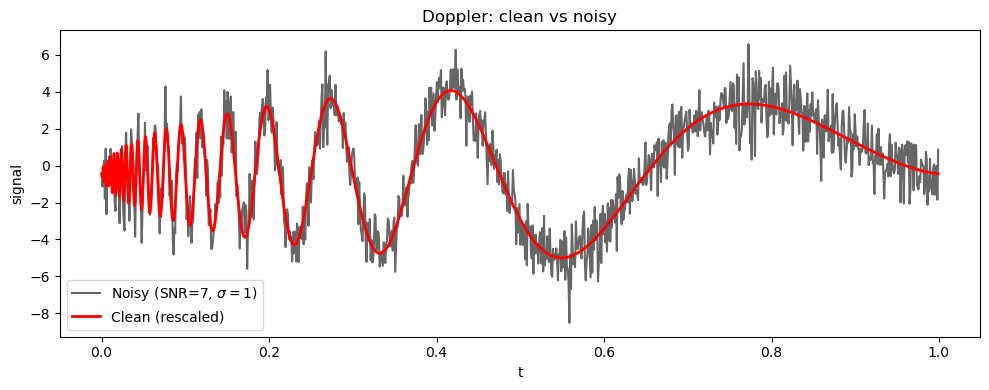

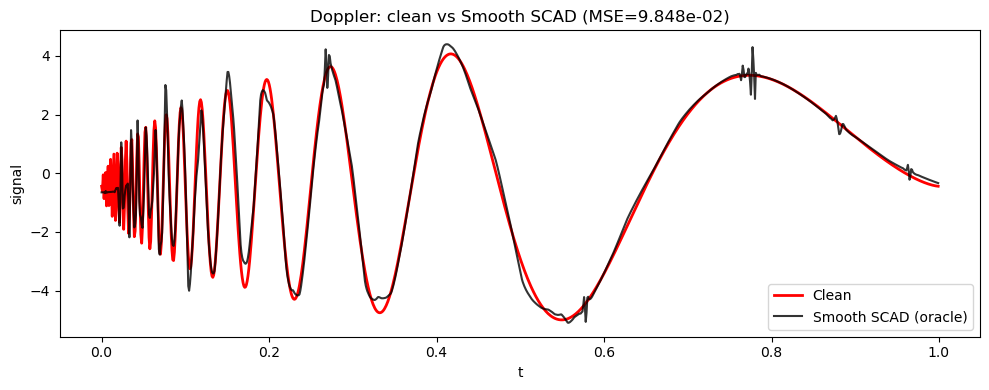

In [1]:
# %%
import numpy as np
import matplotlib.pyplot as plt
import pywt

np.random.seed(62)

# %% [markdown]
# ## Doppler and SNR rescaling

# %%
def doppler_signal(N):
    """
    Donoho–Johnstone Doppler test function on [0,1] with N points.
    """
    t = np.linspace(0, 1, N, endpoint=False)
    eps = 1e-10
    t_safe = np.maximum(t, eps)
    f = np.sqrt(t_safe * (1 - t_safe)) * np.sin((2 * np.pi * 1.05) / (t_safe + 0.05))
    return f

def rescale_for_snr(signal, snr, sigma=1.0):
    """
    Rescale 'signal' so that Var(signal_rescaled) / Var(noise) = snr,
    with Var(noise) = sigma^2.
    """
    signal_centered = signal - np.mean(signal)
    var_signal = np.var(signal_centered)
    if var_signal <= 0:
        raise ValueError("Signal variance is zero or negative; cannot rescale for SNR.")
    desired_var = snr * sigma**2
    scale = np.sqrt(desired_var / var_signal)
    return scale * signal_centered

# %% [markdown]
# ## Smooth SCAD shrinker and denoising helpers

# %%
def sscad_shrink(coeffs, lam, a=3.0):
    """
    Smooth SCAD (raised–cosine) shrinkage applied elementwise.
    - lam: main threshold > 0
    - a: upper factor > 1 (controls width of [lam, a*lam])
    """
    x = coeffs
    ax = np.abs(x)
    s = np.sign(x)

    out = np.zeros_like(x)

    # |x| <= lambda -> 0 (already zero)

    # lambda < |x| < a*lambda
    idx_mid = (ax > lam) & (ax < a * lam)
    if np.any(idx_mid):
        d_mid = ax[idx_mid]
        s_param = (d_mid - lam) / ((a - 1) * lam)
        h_mid = lam * np.cos(0.5 * np.pi * s_param)**2
        out[idx_mid] = s[idx_mid] * (d_mid - h_mid)

    # |x| >= a*lambda -> identity
    idx_large = ax >= a * lam
    out[idx_large] = x[idx_large]

    return out

def denoise_with_sscad(y, wavelet_name, lam, a, level=None):
    """
    Wavelet denoising with Smooth SCAD on all detail levels.
    """
    wavelet = pywt.Wavelet(wavelet_name)
    if level is None:
        level = pywt.dwt_max_level(len(y), wavelet.dec_len)
    coeffs = pywt.wavedec(y, wavelet, level=level)
    cA = coeffs[0]
    cDs = coeffs[1:]

    cDs_shrunk = [sscad_shrink(cD, lam, a) for cD in cDs]
    coeffs_shrunk = [cA] + cDs_shrunk
    y_rec = pywt.waverec(coeffs_shrunk, wavelet)
    return y_rec[:len(y)]

def oracle_lambda_sscad(x_clean, y_noisy, wavelet_name, a,
                        lam_min_factor=0.2, lam_max_factor=3.0,
                        num_lams=40, sigma=1.0):
    """
    Oracle: choose lambda minimizing MSE between SSCAD reconstruction
    and clean signal, on a grid around sqrt(2 log N).
    """
    N = len(x_clean)
    lam0 = sigma * np.sqrt(2 * np.log(N))
    lam_grid = np.linspace(lam_min_factor * lam0,
                           lam_max_factor * lam0,
                           num_lams)

    best_lam = lam_grid[0]
    best_mse = np.inf
    wavelet = pywt.Wavelet(wavelet_name)
    level = pywt.dwt_max_level(N, wavelet.dec_len)

    for lam in lam_grid:
        x_rec = denoise_with_sscad(y_noisy, wavelet_name, lam, a, level=level)
        mse = np.mean((x_rec - x_clean)**2)
        if mse < best_mse:
            best_mse = mse
            best_lam = lam

    return best_lam, best_mse

# %% [markdown]
# ## Single experiment: Doppler, SNR=7, Smooth SCAD

# %%
# Parameters
N = 1024
snr = 7.0
sigma = 1.0
wavelet_name = 'sym4'
a_sscad = 2.0

# Clean, rescaled Doppler
x_clean_raw = doppler_signal(N)
x_clean = rescale_for_snr(x_clean_raw, snr=snr, sigma=sigma)

# Noise and noisy signal
noise = np.random.normal(0.0, sigma, size=N)
y_noisy = x_clean + noise

# Oracle Smooth SCAD
lam_sscad, mse_sscad = oracle_lambda_sscad(
    x_clean, y_noisy, wavelet_name, a_sscad,
    lam_min_factor=0.2, lam_max_factor=3.0,
    num_lams=40, sigma=sigma
)
x_sscad = denoise_with_sscad(y_noisy, wavelet_name, lam_sscad, a_sscad)

print(f"Smooth SCAD: lambda* = {lam_sscad:.4f}, MSE = {mse_sscad:.4e}")

# %% [markdown]
# ## Plots
# 1. Clean vs noisy  
# 2. Clean vs Smooth SCAD reconstruction (overlay)

# %%
t = np.linspace(0, 1, N, endpoint=False)

# (1) Clean vs noisy
plt.figure(figsize=(10, 4))
plt.plot(t, y_noisy, label='Noisy (SNR=7, $\sigma=1$)', color='black', alpha=0.6)
plt.plot(t, x_clean, label='Clean (rescaled)', color='red', linewidth=2)
plt.xlabel('t')
plt.ylabel('signal')
plt.title('Doppler: clean vs noisy')
plt.legend()
plt.tight_layout()
#plt.savefig("noisydopp.png", dpi=300, bbox_inches="tight")
#plt.savefig("noisydopp.pdf",  bbox_inches="tight")
plt.show()

# (2) Clean vs Smooth SCAD reconstruction
plt.figure(figsize=(10, 4))
plt.plot(t, x_clean, label='Clean', color='red', linewidth=2)
plt.plot(t, x_sscad, label='Smooth SCAD (oracle)', color='black', alpha=0.8)
plt.xlabel('t')
plt.ylabel('signal')
plt.title(f'Doppler: clean vs Smooth SCAD (MSE={mse_sscad:.3e})')
plt.legend()
plt.tight_layout()
#plt.savefig("sscaddopp.png", dpi=300, bbox_inches="tight")
#plt.savefig("sscaddopp.pdf",  bbox_inches="tight")
plt.show()